In [11]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
import math

import c2qa
import c2qa.util
import c2qa.wigner
import matplotlib.pyplot
import numpy
import qiskit

## Displacement Gate Calibration
The following circuit is a way to calibrate the conditional displacement gate. 

In [20]:
def calibration_circuit(dist, num_qumodes = 1, num_qubits_per_qumode = 4):
    qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_qumode=num_qubits_per_qumode)
    qr = qiskit.QuantumRegister(size=1)
    cr = qiskit.ClassicalRegister(size=1)
    circuit = c2qa.CVCircuit(qmr, qr, cr)

    circuit.initialize([1,0], qr[0])
    circuit.cv_initialize(0, qmr[0])

    circuit.h(qr[0])
    circuit.cv_c_d(dist, qmr[0], qr[0])
    circuit.cv_d(1j * dist, qmr[0])
    circuit.cv_c_d(-dist, qmr[0], qr[0])
    circuit.cv_d(-1j * dist, qmr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0], cr[0])

    return circuit, qr[0], cr[0]

## Simulate one shot to plot Wigner function 
The statevector_simulator produces a state vector output. Then use the state vector to plot the Wigner function using the c2qa.util module.

In [14]:
circuit, _, _  = calibration_circuit(numpy.sqrt(numpy.pi) / numpy.sqrt(2))
backend = qiskit.Aer.get_backend("statevector_simulator")
job = qiskit.execute(circuit, backend)
result = job.result()

state = result.get_statevector(circuit)
counts = result.get_counts(circuit)

print("Simulated statevector:")
print(state)
print("Simulated result counts:")
print(counts)

c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Simulated statevector:
[-9.99999967e-01+9.06433093e-12j  3.49067364e-14+1.41499249e-06j
 -6.78787253e-06-4.20309991e-14j  6.53338162e-15-8.74957994e-06j
 -2.80769767e-05-1.24845823e-14j -3.29978785e-14-1.07346996e-04j
  9.49687008e-05+2.90013601e-14j  3.50799524e-14-6.76692003e-05j
  8.63810684e-05-1.60872616e-14j -9.49185956e-16-7.18481148e-05j
 -1.68382058e-05+1.50087747e-14j  1.66921548e-14-8.43754939e-05j
 -7.49838562e-05-3.69582286e-15j -9.43031776e-16+2.08858618e-05j
  3.15316355e-05-1.89095458e-14j  1.53980480e-15+1.09546757e-04j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
 -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  

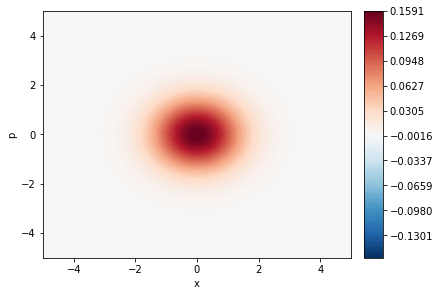

In [15]:
# Plot Fock state Wigner function
c2qa.wigner.plot_wigner(circuit, state)

## Iterate over incremental displacements
Iteratively simulate the calibration cicruit with incremental differences in the displacement and plot probability difference results.

In [16]:
# Run the simulations
backend = qiskit.Aer.get_backend("qasm_simulator")
up = numpy.linspace(numpy.sqrt(2), 2, 20)
down = numpy.linspace(2, numpy.sqrt(2), 20)
steps = []

for _ in range(2):
    steps.extend(up[0:19])
    steps.extend(down[0:19])

x = []
y = []

for i, step in enumerate(steps):
    dist = numpy.sqrt(numpy.pi) / step
    circuit, _, _ = calibration_circuit(dist)

    job = qiskit.execute(circuit, backend, shots=32)
    result = job.result()

    counts = result.get_counts(circuit)

    x.append(i)
    y.append(counts.get("0", 0) - counts.get("1", 0))

    print(f"{i}: {counts}")

0: {'0': 32}
1: {'1': 2, '0': 30}
2: {'0': 31, '1': 1}
3: {'0': 29, '1': 3}
4: {'0': 25, '1': 7}
5: {'0': 23, '1': 9}
6: {'0': 17, '1': 15}
7: {'0': 18, '1': 14}
8: {'0': 11, '1': 21}
9: {'1': 21, '0': 11}
10: {'1': 20, '0': 12}
11: {'1': 22, '0': 10}
12: {'1': 27, '0': 5}
13: {'1': 28, '0': 4}
14: {'1': 30, '0': 2}
15: {'1': 30, '0': 2}
16: {'1': 31, '0': 1}
17: {'1': 32}
18: {'1': 32}
19: {'1': 32}
20: {'1': 32}
21: {'1': 32}
22: {'1': 30, '0': 2}
23: {'1': 31, '0': 1}
24: {'1': 30, '0': 2}
25: {'1': 29, '0': 3}
26: {'1': 27, '0': 5}
27: {'1': 26, '0': 6}
28: {'1': 22, '0': 10}
29: {'1': 22, '0': 10}
30: {'0': 19, '1': 13}
31: {'1': 15, '0': 17}
32: {'0': 20, '1': 12}
33: {'0': 26, '1': 6}
34: {'0': 27, '1': 5}
35: {'0': 26, '1': 6}
36: {'0': 29, '1': 3}
37: {'0': 32}
38: {'0': 32}
39: {'0': 29, '1': 3}
40: {'0': 29, '1': 3}
41: {'0': 29, '1': 3}
42: {'0': 29, '1': 3}
43: {'1': 11, '0': 21}
44: {'0': 23, '1': 9}
45: {'0': 21, '1': 11}
46: {'0': 12, '1': 20}
47: {'1': 22, '0': 10}
48:

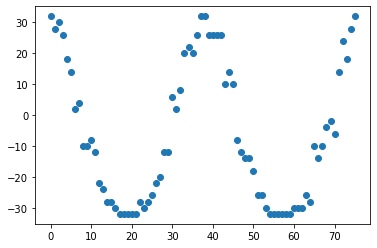

In [17]:
# Plot the results
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.show()

## Animate the circuit

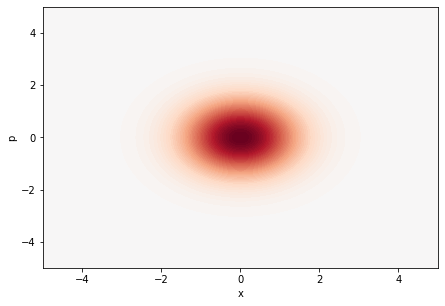

In [21]:
circuit, qubit, cbit  = calibration_circuit(dist=numpy.sqrt(numpy.pi) / numpy.sqrt(2))

anim = c2qa.animate.animate_wigner(circuit, qubit=qubit, cbit=cbit, animation_segments=10)

In [22]:
from IPython.display import HTML
HTML(anim.to_html5_video())